In [1]:
import os
import numpy as np
import torch
import random
from torchvision import transforms
from normalize import Normalize, MapToRange
from torch.utils.data import Dataset, DataLoader

from torch import nn
from torch.nn import *

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
torch.set_num_threads(1)

print(torch.cuda.is_available())

False


**Preprocessing the dataset**

In [2]:
class TrajectoryDataset(Dataset):
    
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        i, j = self.indices[index]        
        X = torch.tensor([
            self.dataset['dx'][i, j],
            self.dataset['dy'][i, j],
            self.dataset['dz'][i, j],
            self.dataset['vx'][i, j],
            self.dataset['vy'][i, j],
            self.dataset['vz'][i, j],
            self.dataset['phi'][i, j],
            self.dataset['theta'][i, j],
            self.dataset['psi'][i, j],
            self.dataset['p'][i, j],
            self.dataset['q'][i, j],
            self.dataset['r'][i, j],
            self.dataset['omega'][i, j, 0],
            self.dataset['omega'][i, j, 1],
            self.dataset['omega'][i, j, 2],
            self.dataset['omega'][i, j, 3],
#             self.dataset['Mx_ext'][i],
#             self.dataset['My_ext'][i],
#             self.dataset['Mz_ext'][i]
        ], dtype=torch.float32)
        
        U = torch.tensor([
            self.dataset['u'][i, j, 0],
            self.dataset['u'][i, j, 1],
            self.dataset['u'][i, j, 2],
            self.dataset['u'][i, j, 3]
        ], dtype=torch.float32)
        
        return X, U
    
# trajectories containing 199 points
dataset_path = 'datasets/HOVER_TO_HOVER_NOMINAL.npz'

dataset = dict()
print('loading dataset...')
# See all keys and shapes
# with np.load(dataset_path) as data:
#     for key in data.files:
#         print(key, data[key].shape)

with np.load(dataset_path) as full_dataset:
    # total number of trajectories
    num = len(full_dataset['dx'])
    print(num, 'trajectories')
    dataset = {key: full_dataset[key] for key in [
        't', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'p', 'q', 'r','omega', 'u', 'omega_min','omega_max', 'k_omega', 'Mx_ext', 'My_ext', 'Mz_ext'
    ]}

# train/test split
batchsize_train = 256
batchsize_val = 256
train_trajectories = range(int(0.8*num))
test_trajectories = list(set(range(num)) - set(train_trajectories))

train_indices = [(i, j) for i in train_trajectories for j in range(199)]
train_set = TrajectoryDataset(dataset, train_indices)
train_loader = DataLoader(train_set, batch_size=batchsize_train, shuffle=True, num_workers=1)

test_indices = [(i, j) for i in test_trajectories for j in range(199)]
test_set = TrajectoryDataset(dataset, test_indices)
test_loader = DataLoader(test_set, batch_size=batchsize_val, shuffle=True, num_workers=1)

print('ready')

print('Amount of testing trajectories: ',len(test_trajectories),f'(Batchsize: {batchsize_val})')
print('Amount of training trajectories: ',len(train_trajectories),f'(Batchsize: {batchsize_train})')

loading dataset...
1000 trajectories
ready
Amount of testing trajectories:  200 (Batchsize: 256)
Amount of training trajectories:  800 (Batchsize: 256)


In [3]:
print(len(test_trajectories))
print(len(train_trajectories))

print(dataset['omega_min'])
print(dataset['omega_max'])

200
800
[5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500
 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 5500 550

**Calculating mean and standard deviation for normalization**

In [4]:
from tqdm import tqdm
X_mean = torch.zeros(16)
X_std = torch.zeros(16)

N=10000

for i, data in tqdm(enumerate(test_set)):
    X = data[0]
    X_mean += X
    if i>=N:
        break
X_mean = X_mean/N

print('mean:')
print(X_mean)
    
for i, data in tqdm(enumerate(test_set)):
    X = data[0]
    X_std += (X-X_mean)**2
    if i>=N:
        break

X_std = torch.sqrt(X_std/N)
print('std:')
print(X_std)

10000it [00:00, 27796.32it/s]


mean:
tensor([ 3.3701e-01, -9.1579e-02, -5.4900e-01,  3.5883e-01, -1.6437e-01,
        -9.6327e-02,  8.0173e-03, -2.4643e-02,  2.0312e-02,  2.3068e-02,
         6.6097e-02,  2.1455e-02,  7.5845e+03,  7.6346e+03,  7.7458e+03,
         7.7316e+03])


10000it [00:00, 31104.82it/s]

std:
tensor([1.5155e+00, 1.5785e+00, 9.2298e-01, 1.3282e+00, 1.5455e+00, 5.1556e-01,
        2.7391e-01, 2.5689e-01, 1.2481e+00, 1.2782e+00, 1.1084e+00, 1.1385e+00,
        5.8533e+02, 6.2485e+02, 5.4435e+02, 6.2526e+02])


**Defining the neural network**

In [17]:
class CustomSigmoid(nn.Module):
    def forward(self, x):
        return torch.clamp((-1 / 2048) * x**2 + 0.25 * x + 32, 0.0, 1.0)
    
class PiecewiseSigmoid(nn.Module):
    def forward(self, x):
        return torch.where(x < -2.5, torch.zeros_like(x),
               torch.where(x > 2.5, torch.ones_like(x),
               0.2 * x + 0.5))
class TanhSigmoid(nn.Module):
    def forward(self, x):
        return 0.5 * (torch.tanh(x / 2) + 1)
    

class HardSigmoid(nn.Module):
    def forward(self, x):
        return torch.clamp(0.2 * x + 0.5, min=0.0, max=1.0)

class FastSigmoid(nn.Module):
    def forward(self, x):
        return x / (1 + torch.abs(x))

# model = nn.Sequential(
#     Normalize(),
#     nn.Linear(16, 120),
#     nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
#     nn.ReLU(),
#     nn.Linear(120, 120),
#     nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
#     nn.ReLU(),
#     nn.Linear(120, 120),
#     nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
#     nn.ReLU(),
#     nn.Linear(120, 4),
#     nn.BatchNorm1d(4, eps=1e-4, momentum=0.1),
#     nn.Sigmoid()
# )

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            Normalize,
            nn.Linear(16, 120),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1),
            nn.ReLU(),
            nn.Linear(120, 4),
            nn.BatchNorm1d(4, eps=1e-4, momentum=0.1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)  # Apply normalization before feeding into network
        return self.net(x)

model = Model()
print(model)

Model(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=120, bias=True)
    (4): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=120, out_features=120, bias=True)
    (7): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=4, bias=True)
    (10): BatchNorm1d(4, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)


**Testing**

In [18]:
model.eval()
x1 = torch.randn(1,16)
print(model(x1))
# print([param.shape for param in model.parameters()])

tensor([[0.4712, 0.4926, 0.4856, 0.5069]], grad_fn=<SigmoidBackward0>)


**Define a Loss function and optimizer**

In [19]:
criterion = torch.nn.MSELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=1,  threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


**Training loop**

In [20]:
from tqdm import tqdm
import time
import copy

loss_list = []
loss_val_list = []
best_loss = 0.1
first = True
start_time = time.time()

# loop over the dataset multiple times
num_epochs = 100

nn_model_name = f"{dataset_path[9:-4]}_{batchsize_train}_{batchsize_val}_{learning_rate}_{num_epochs}"
model.train()

for epoch in range(num_epochs):
    
    if first:
        time_remaining = '-'
    else:
        time_estimate = epoch_time*(num_epochs-epoch+1)
        if time_estimate > 60:
            if time_estimate > 3600:
                time_remaining = str(round(time_estimate/3600,2))+' h'
            else:
                time_remaining = str(round(time_estimate/60,2))+' min'
        else:
            time_remaining = str(round(time_estimate,0))+' s'
        
    first = False
    print(f"Epoch {epoch+1}/{num_epochs}, Current learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}, Time remaining: {time_remaining}")

    start_time_epoch = time.time()
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    for i, (data, targets) in loop:
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Update progressbar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
        loss_list.append(loss.item())

    # Validate
    with torch.no_grad():
        # Get a random batch from the test dataset
        data_val, targets_val = next(iter(test_loader))

        # Forward pass
        outputs_val = model(data_val)

        # Loss
        loss_val = criterion(outputs_val, targets_val)

        if loss_val < best_loss:
            # Save best model
            best_model = copy.deepcopy(model)
            
            # Backup
            torch.save(model, 'neural_networks/tmp_benchmark.pt')
            
            best_loss = loss_val
            print("Best model updated!")

        # Scheduler (reduce learning rate if loss stagnates)
        scheduler.step(loss_val)
        
        loss_val_list.append(loss_val.item())

    # print("Running mean:", model[2].running_mean[:5])
    # print("Running var:", model[2].running_var[:5])
    print(f'loss = {loss:.8f}, loss validation = {loss_val:.8f} '+r' (control error: +/-'+str(round(100*np.sqrt(float(loss_val)),2))+'%)\n')

    epoch_time = (time.time() - start_time_epoch)

    loop.close()
    
# Compute excecution time
execution_time = (time.time() - start_time)    
print(f"Total training time: {round(execution_time,2)}s")

# Save best model and copy for maptorange network
torch.save(best_model, f'neural_networks/{nn_model_name}.pt')
best_model_for_maptorange = torch.load('neural_networks/tmp_benchmark.pt', weights_only=False)
print(best_model_for_maptorange)

Epoch 1/100, Current learning rate: 0.0001, Time remaining: -


Best model updated!
loss = 0.02036113, loss validation = 0.01720340  (control error: +/-13.12%)

Epoch 2/100, Current learning rate: 0.0001, Time remaining: 20.22 min


Best model updated!
loss = 0.01509170, loss validation = 0.01618333  (control error: +/-12.72%)

Epoch 3/100, Current learning rate: 0.0001, Time remaining: 17.93 min


loss = 0.01728123, loss validation = 0.01830957  (control error: +/-13.53%)

Epoch 4/100, Current learning rate: 0.0001, Time remaining: 17.66 min


loss = 0.01587638, loss validation = 0.01844114  (control error: +/-13.58%)

Epoch 5/100, Current learning rate: 9e-05, Time remaining: 16.71 min


loss = 0.01365461, loss validation = 0.01713798  (control error: +/-13.09%)

Epoch 6/100, Current learning rate: 9e-05, Time remaining: 16.54 min


Best model updated!
loss = 0.01362213, loss validation = 0.01270195  (control error: +/-11.27%)

Epoch 7/100, Current learning rate: 9e-05, Time remaining: 18.12 min


Best model updated!
loss = 0.01712695, loss validation = 0.01136784  (control error: +/-10.66%)

Epoch 8/100, Current learning rate: 9e-05, Time remaining: 17.1 min


Best model updated!
loss = 0.01070078, loss validation = 0.01133617  (control error: +/-10.65%)

Epoch 9/100, Current learning rate: 9e-05, Time remaining: 14.92 min


Best model updated!
loss = 0.01084365, loss validation = 0.01060744  (control error: +/-10.3%)

Epoch 10/100, Current learning rate: 9e-05, Time remaining: 15.85 min


loss = 0.01333493, loss validation = 0.01120008  (control error: +/-10.58%)

Epoch 11/100, Current learning rate: 9e-05, Time remaining: 16.45 min


loss = 0.01232589, loss validation = 0.01102247  (control error: +/-10.5%)

Epoch 12/100, Current learning rate: 8.1e-05, Time remaining: 14.63 min


loss = 0.01390090, loss validation = 0.01184290  (control error: +/-10.88%)

Epoch 13/100, Current learning rate: 8.1e-05, Time remaining: 14.34 min


Best model updated!
loss = 0.01054451, loss validation = 0.00893117  (control error: +/-9.45%)

Epoch 14/100, Current learning rate: 8.1e-05, Time remaining: 15.06 min


loss = 0.01077561, loss validation = 0.01109010  (control error: +/-10.53%)

Epoch 15/100, Current learning rate: 8.1e-05, Time remaining: 15.73 min


loss = 0.01439033, loss validation = 0.01388107  (control error: +/-11.78%)

Epoch 16/100, Current learning rate: 7.290000000000001e-05, Time remaining: 16.57 min


loss = 0.00903299, loss validation = 0.00989478  (control error: +/-9.95%)

Epoch 17/100, Current learning rate: 7.290000000000001e-05, Time remaining: 16.78 min


loss = 0.01341706, loss validation = 0.01050905  (control error: +/-10.25%)

Epoch 18/100, Current learning rate: 6.561000000000002e-05, Time remaining: 13.34 min


loss = 0.00730772, loss validation = 0.00966501  (control error: +/-9.83%)

Epoch 19/100, Current learning rate: 6.561000000000002e-05, Time remaining: 14.58 min


loss = 0.00937558, loss validation = 0.00928960  (control error: +/-9.64%)

Epoch 20/100, Current learning rate: 5.904900000000002e-05, Time remaining: 13.91 min


loss = 0.00834026, loss validation = 0.00924275  (control error: +/-9.61%)

Epoch 21/100, Current learning rate: 5.904900000000002e-05, Time remaining: 16.03 min


loss = 0.00912096, loss validation = 0.00989275  (control error: +/-9.95%)

Epoch 22/100, Current learning rate: 5.314410000000002e-05, Time remaining: 14.53 min


loss = 0.00917337, loss validation = 0.01185581  (control error: +/-10.89%)

Epoch 23/100, Current learning rate: 5.314410000000002e-05, Time remaining: 13.56 min


Best model updated!
loss = 0.00797816, loss validation = 0.00759575  (control error: +/-8.72%)

Epoch 24/100, Current learning rate: 5.314410000000002e-05, Time remaining: 13.39 min


loss = 0.00911715, loss validation = 0.01171445  (control error: +/-10.82%)

Epoch 25/100, Current learning rate: 5.314410000000002e-05, Time remaining: 15.76 min


loss = 0.00800169, loss validation = 0.00795155  (control error: +/-8.92%)

Epoch 26/100, Current learning rate: 4.782969000000002e-05, Time remaining: 16.29 min


loss = 0.01234773, loss validation = 0.01036162  (control error: +/-10.18%)

Epoch 27/100, Current learning rate: 4.782969000000002e-05, Time remaining: 13.55 min


loss = 0.00616357, loss validation = 0.00842437  (control error: +/-9.18%)

Epoch 28/100, Current learning rate: 4.304672100000002e-05, Time remaining: 13.55 min


loss = 0.00665324, loss validation = 0.00995394  (control error: +/-9.98%)

Epoch 29/100, Current learning rate: 4.304672100000002e-05, Time remaining: 13.8 min


loss = 0.00991095, loss validation = 0.00892151  (control error: +/-9.45%)

Epoch 30/100, Current learning rate: 3.874204890000002e-05, Time remaining: 12.4 min


loss = 0.00958785, loss validation = 0.00783783  (control error: +/-8.85%)

Epoch 31/100, Current learning rate: 3.874204890000002e-05, Time remaining: 14.44 min


loss = 0.00748275, loss validation = 0.01019649  (control error: +/-10.1%)

Epoch 32/100, Current learning rate: 3.4867844010000016e-05, Time remaining: 12.32 min


loss = 0.00849542, loss validation = 0.00929008  (control error: +/-9.64%)

Epoch 33/100, Current learning rate: 3.4867844010000016e-05, Time remaining: 11.41 min


loss = 0.01168212, loss validation = 0.01077008  (control error: +/-10.38%)

Epoch 34/100, Current learning rate: 3.138105960900002e-05, Time remaining: 10.78 min


loss = 0.00828048, loss validation = 0.00927838  (control error: +/-9.63%)

Epoch 35/100, Current learning rate: 3.138105960900002e-05, Time remaining: 11.94 min


loss = 0.00646818, loss validation = 0.01126226  (control error: +/-10.61%)

Epoch 36/100, Current learning rate: 2.8242953648100018e-05, Time remaining: 12.53 min


loss = 0.00961856, loss validation = 0.01194838  (control error: +/-10.93%)

Epoch 37/100, Current learning rate: 2.8242953648100018e-05, Time remaining: 11.1 min


loss = 0.00922580, loss validation = 0.00844793  (control error: +/-9.19%)

Epoch 38/100, Current learning rate: 2.5418658283290016e-05, Time remaining: 11.98 min


loss = 0.00677198, loss validation = 0.01166978  (control error: +/-10.8%)

Epoch 39/100, Current learning rate: 2.5418658283290016e-05, Time remaining: 10.84 min


loss = 0.00784339, loss validation = 0.01176323  (control error: +/-10.85%)

Epoch 40/100, Current learning rate: 2.2876792454961016e-05, Time remaining: 10.63 min


loss = 0.00787040, loss validation = 0.01156881  (control error: +/-10.76%)

Epoch 41/100, Current learning rate: 2.2876792454961016e-05, Time remaining: 10.54 min


loss = 0.00711003, loss validation = 0.01229516  (control error: +/-11.09%)

Epoch 42/100, Current learning rate: 2.0589113209464913e-05, Time remaining: 9.9 min


loss = 0.00899154, loss validation = 0.01423117  (control error: +/-11.93%)

Epoch 43/100, Current learning rate: 2.0589113209464913e-05, Time remaining: 9.66 min


loss = 0.00899289, loss validation = 0.00803255  (control error: +/-8.96%)

Epoch 44/100, Current learning rate: 1.8530201888518422e-05, Time remaining: 9.02 min


loss = 0.00836571, loss validation = 0.00957961  (control error: +/-9.79%)

Epoch 45/100, Current learning rate: 1.8530201888518422e-05, Time remaining: 9.59 min


loss = 0.00533646, loss validation = 0.00913048  (control error: +/-9.56%)

Epoch 46/100, Current learning rate: 1.667718169966658e-05, Time remaining: 8.86 min


loss = 0.00536386, loss validation = 0.00852139  (control error: +/-9.23%)

Epoch 47/100, Current learning rate: 1.667718169966658e-05, Time remaining: 9.18 min


loss = 0.00707323, loss validation = 0.00783103  (control error: +/-8.85%)

Epoch 48/100, Current learning rate: 1.5009463529699922e-05, Time remaining: 9.48 min


loss = 0.00950547, loss validation = 0.00915016  (control error: +/-9.57%)

Epoch 49/100, Current learning rate: 1.5009463529699922e-05, Time remaining: 9.42 min


loss = 0.00871263, loss validation = 0.00792811  (control error: +/-8.9%)

Epoch 50/100, Current learning rate: 1.350851717672993e-05, Time remaining: 7.72 min


loss = 0.00632136, loss validation = 0.00964103  (control error: +/-9.82%)

Epoch 51/100, Current learning rate: 1.350851717672993e-05, Time remaining: 8.09 min


loss = 0.00816742, loss validation = 0.00876891  (control error: +/-9.36%)

Epoch 52/100, Current learning rate: 1.2157665459056937e-05, Time remaining: 8.61 min


loss = 0.00765552, loss validation = 0.00856933  (control error: +/-9.26%)

Epoch 53/100, Current learning rate: 1.2157665459056937e-05, Time remaining: 7.85 min


loss = 0.00921157, loss validation = 0.00969475  (control error: +/-9.85%)

Epoch 54/100, Current learning rate: 1.0941898913151244e-05, Time remaining: 7.69 min


loss = 0.01015895, loss validation = 0.00944990  (control error: +/-9.72%)

Epoch 55/100, Current learning rate: 1.0941898913151244e-05, Time remaining: 7.72 min


Best model updated!
loss = 0.01075449, loss validation = 0.00753916  (control error: +/-8.68%)

Epoch 56/100, Current learning rate: 1.0941898913151244e-05, Time remaining: 8.74 min


loss = 0.00804012, loss validation = 0.00826207  (control error: +/-9.09%)

Epoch 57/100, Current learning rate: 1.0941898913151244e-05, Time remaining: 7.59 min


loss = 0.00876149, loss validation = 0.00868959  (control error: +/-9.32%)

Epoch 58/100, Current learning rate: 9.84770902183612e-06, Time remaining: 7.54 min


loss = 0.00727274, loss validation = 0.00822071  (control error: +/-9.07%)

Epoch 59/100, Current learning rate: 9.84770902183612e-06, Time remaining: 7.31 min


Best model updated!
loss = 0.00679821, loss validation = 0.00575476  (control error: +/-7.59%)

Epoch 60/100, Current learning rate: 9.84770902183612e-06, Time remaining: 7.28 min


loss = 0.00862820, loss validation = 0.00830394  (control error: +/-9.11%)

Epoch 61/100, Current learning rate: 9.84770902183612e-06, Time remaining: 6.57 min


loss = 0.00828490, loss validation = 0.00613810  (control error: +/-7.83%)

Epoch 62/100, Current learning rate: 8.862938119652508e-06, Time remaining: 6.56 min


loss = 0.00646246, loss validation = 0.01013632  (control error: +/-10.07%)

Epoch 63/100, Current learning rate: 8.862938119652508e-06, Time remaining: 6.62 min


loss = 0.00704956, loss validation = 0.01191892  (control error: +/-10.92%)

Epoch 64/100, Current learning rate: 7.976644307687257e-06, Time remaining: 6.6 min


loss = 0.00660769, loss validation = 0.01156071  (control error: +/-10.75%)

Epoch 65/100, Current learning rate: 7.976644307687257e-06, Time remaining: 5.99 min


loss = 0.00731421, loss validation = 0.01000753  (control error: +/-10.0%)

Epoch 66/100, Current learning rate: 7.1789798769185315e-06, Time remaining: 5.81 min


loss = 0.01034703, loss validation = 0.00856968  (control error: +/-9.26%)

Epoch 67/100, Current learning rate: 7.1789798769185315e-06, Time remaining: 6.22 min


loss = 0.00681767, loss validation = 0.00690883  (control error: +/-8.31%)

Epoch 68/100, Current learning rate: 6.461081889226678e-06, Time remaining: 6.61 min


loss = 0.00802910, loss validation = 0.00659845  (control error: +/-8.12%)

Epoch 69/100, Current learning rate: 6.461081889226678e-06, Time remaining: 5.2 min


loss = 0.00724401, loss validation = 0.00892544  (control error: +/-9.45%)

Epoch 70/100, Current learning rate: 5.81497370030401e-06, Time remaining: 5.06 min


loss = 0.00850273, loss validation = 0.00938941  (control error: +/-9.69%)

Epoch 71/100, Current learning rate: 5.81497370030401e-06, Time remaining: 5.27 min


loss = 0.00719419, loss validation = 0.01033431  (control error: +/-10.17%)

Epoch 72/100, Current learning rate: 5.23347633027361e-06, Time remaining: 5.33 min


loss = 0.00570308, loss validation = 0.00891917  (control error: +/-9.44%)

Epoch 73/100, Current learning rate: 5.23347633027361e-06, Time remaining: 5.01 min


loss = 0.00853293, loss validation = 0.00944088  (control error: +/-9.72%)

Epoch 74/100, Current learning rate: 4.710128697246249e-06, Time remaining: 4.54 min


loss = 0.00690256, loss validation = 0.01023583  (control error: +/-10.12%)

Epoch 75/100, Current learning rate: 4.710128697246249e-06, Time remaining: 4.32 min


loss = 0.00620374, loss validation = 0.00858923  (control error: +/-9.27%)

Epoch 76/100, Current learning rate: 4.239115827521624e-06, Time remaining: 4.52 min


loss = 0.00620079, loss validation = 0.00906867  (control error: +/-9.52%)

Epoch 77/100, Current learning rate: 4.239115827521624e-06, Time remaining: 3.82 min


loss = 0.00917360, loss validation = 0.01152996  (control error: +/-10.74%)

Epoch 78/100, Current learning rate: 3.815204244769462e-06, Time remaining: 3.65 min


loss = 0.00611825, loss validation = 0.00905819  (control error: +/-9.52%)

Epoch 79/100, Current learning rate: 3.815204244769462e-06, Time remaining: 3.76 min


loss = 0.00888631, loss validation = 0.01015969  (control error: +/-10.08%)

Epoch 80/100, Current learning rate: 3.4336838202925156e-06, Time remaining: 3.69 min


loss = 0.01009879, loss validation = 0.00869924  (control error: +/-9.33%)

Epoch 81/100, Current learning rate: 3.4336838202925156e-06, Time remaining: 3.35 min


loss = 0.00768556, loss validation = 0.00987449  (control error: +/-9.94%)

Epoch 82/100, Current learning rate: 3.090315438263264e-06, Time remaining: 3.41 min


loss = 0.00773828, loss validation = 0.00918246  (control error: +/-9.58%)

Epoch 83/100, Current learning rate: 3.090315438263264e-06, Time remaining: 3.27 min


loss = 0.00967983, loss validation = 0.00911028  (control error: +/-9.54%)

Epoch 84/100, Current learning rate: 2.7812838944369375e-06, Time remaining: 3.91 min


loss = 0.00619550, loss validation = 0.00815211  (control error: +/-9.03%)

Epoch 85/100, Current learning rate: 2.7812838944369375e-06, Time remaining: 3.88 min


loss = 0.01064670, loss validation = 0.00795412  (control error: +/-8.92%)

Epoch 86/100, Current learning rate: 2.503155504993244e-06, Time remaining: 2.57 min


loss = 0.00765934, loss validation = 0.00873580  (control error: +/-9.35%)

Epoch 87/100, Current learning rate: 2.503155504993244e-06, Time remaining: 2.41 min


loss = 0.00702556, loss validation = 0.00767578  (control error: +/-8.76%)

Epoch 88/100, Current learning rate: 2.2528399544939195e-06, Time remaining: 2.67 min


loss = 0.00590977, loss validation = 0.00899445  (control error: +/-9.48%)

Epoch 89/100, Current learning rate: 2.2528399544939195e-06, Time remaining: 2.42 min


loss = 0.00674479, loss validation = 0.00757378  (control error: +/-8.7%)

Epoch 90/100, Current learning rate: 2.0275559590445276e-06, Time remaining: 2.11 min


loss = 0.00731667, loss validation = 0.01056991  (control error: +/-10.28%)

Epoch 91/100, Current learning rate: 2.0275559590445276e-06, Time remaining: 1.93 min


loss = 0.00789151, loss validation = 0.00769105  (control error: +/-8.77%)

Epoch 92/100, Current learning rate: 1.824800363140075e-06, Time remaining: 1.8 min


loss = 0.00655606, loss validation = 0.00967247  (control error: +/-9.83%)

Epoch 93/100, Current learning rate: 1.824800363140075e-06, Time remaining: 1.67 min


loss = 0.00997842, loss validation = 0.00873200  (control error: +/-9.34%)

Epoch 94/100, Current learning rate: 1.6423203268260674e-06, Time remaining: 1.21 min


loss = 0.00494669, loss validation = 0.01063414  (control error: +/-10.31%)

Epoch 95/100, Current learning rate: 1.6423203268260674e-06, Time remaining: 1.16 min


loss = 0.00932096, loss validation = 0.00719059  (control error: +/-8.48%)

Epoch 96/100, Current learning rate: 1.4780882941434607e-06, Time remaining: 1.03 min


loss = 0.00652162, loss validation = 0.01309941  (control error: +/-11.45%)

Epoch 97/100, Current learning rate: 1.4780882941434607e-06, Time remaining: 51.0 s


loss = 0.00791320, loss validation = 0.00944887  (control error: +/-9.72%)

Epoch 98/100, Current learning rate: 1.3302794647291146e-06, Time remaining: 38.0 s


loss = 0.00738463, loss validation = 0.00742965  (control error: +/-8.62%)

Epoch 99/100, Current learning rate: 1.3302794647291146e-06, Time remaining: 31.0 s


loss = 0.01207430, loss validation = 0.00645606  (control error: +/-8.03%)

Epoch 100/100, Current learning rate: 1.1972515182562032e-06, Time remaining: 24.0 s


loss = 0.00898396, loss validation = 0.00912371  (control error: +/-9.55%)

Total training time: 1045.57s
Model(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=120, bias=True)
    (4): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=120, out_features=120, bias=True)
    (7): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=4, bias=True)
    (10): BatchNorm1d(4, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)


[0.017203399911522865, 0.016183333471417427, 0.018309567123651505, 0.01844113878905773, 0.017137978225946426, 0.012701953761279583, 0.011367838829755783, 0.011336168274283409, 0.01060743909329176, 0.011200081557035446, 0.011022472754120827, 0.011842900887131691, 0.008931167423725128, 0.011090096086263657, 0.013881071470677853, 0.009894775226712227, 0.010509053245186806, 0.009665010496973991, 0.00928959809243679, 0.009242750704288483, 0.009892751462757587, 0.01185581460595131, 0.007595752831548452, 0.01171445194631815, 0.007951552979648113, 0.010361617431044579, 0.008424368686974049, 0.009953941218554974, 0.008921507745981216, 0.007837829180061817, 0.01019649300724268, 0.009290076792240143, 0.010770079679787159, 0.009278384037315845, 0.011262258514761925, 0.01194838248193264, 0.008447927422821522, 0.011669782921671867, 0.011763228103518486, 0.011568812653422356, 0.012295162305235863, 0.014231167733669281, 0.008032547309994698, 0.009579607285559177, 0.009130480699241161, 0.00852139480412

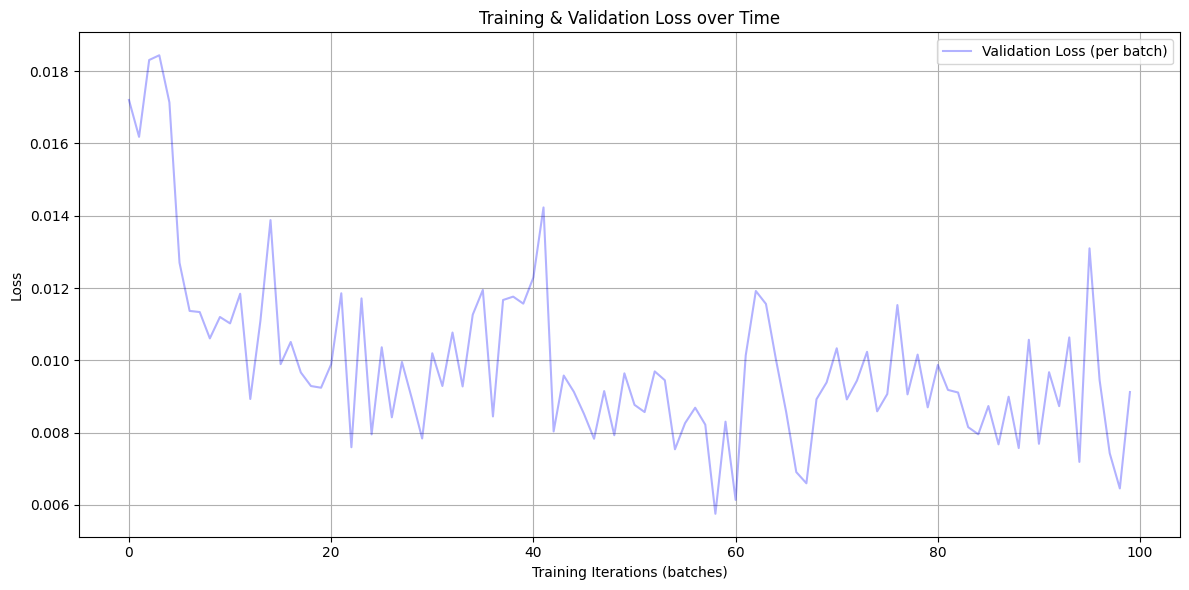

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

# Compute running average (optional: smoother curve)
def running_mean(x, N=100):
    return np.convolve(x, np.ones(N)/N, mode='valid')

# Plotting loss curves
plt.figure(figsize=(12, 6))
plt.plot(loss_val_list, label='Validation Loss (per batch)', color='blue', alpha=0.3)
print(loss_val_list)
# plt.plot(running_mean(loss_list, N=100), label='Training Loss (smoothed)', color='blue')
# print(loss_list)
# plt.plot(
#     np.linspace(0, len(loss_list), len(loss_val_list)), 
#     loss_val_list, label='Validation Loss (per epoch)', color='orange'
# )

plt.xlabel('Training Iterations (batches)')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('training.png')


**Testing performance**

In [22]:
from tqdm import tqdm

loader = test_loader
# loop over the test dataset
loop = tqdm(enumerate(loader), total=len(loader), leave=False)
running_loss = 0

for i, (data, targets) in loop:
    outputs = model(data)
    loss = criterion(outputs, targets)
    
    running_loss += loss.item()
    
    # update progressbar
    loop.set_postfix(loss=loss.item())

loop.close()
print('average loss =', running_loss/len(loader))

average loss = 0.008802767568387283


In [16]:
!ls

 Dataset_Generation.ipynb		    quantized_weight_csvs
 Dataset_Generation_origin.ipynb	    test_out.npz
 Drone.git				    test_out_attempt_0.npz
'Generate C code.ipynb'			    test_out_attempt_1.npz
 HOVER_TO_HOVER_NOMINAL			    test_out_attempt_10.npz
 HOVER_TO_HOVER_NOMINAL.npz		    test_out_attempt_11.npz
'Minimum Snap trajectories.ipynb'	    test_out_attempt_12.npz
 Network_Training.ipynb			    test_out_attempt_13.npz
 README.md				    test_out_attempt_14.npz
 RedBit					    test_out_attempt_15.npz
 Simulation.ipynb			    test_out_attempt_16.npz
 __pycache__				    test_out_attempt_17.npz
 ampl					    test_out_attempt_18.npz
 c_code					    test_out_attempt_19.npz
 datasets				    test_out_attempt_2.npz
 layer_input_boxplots.png		    test_out_attempt_3.npz
 neural_networks			    test_out_attempt_4.npz
 normalize.py				    test_out_attempt_5.npz
 pyquad					    test_out_attempt_6.npz
 quadcopter_animation			    test_out_attempt_7.npz
 quantized_weight_analysis.csv		    test_out_attem

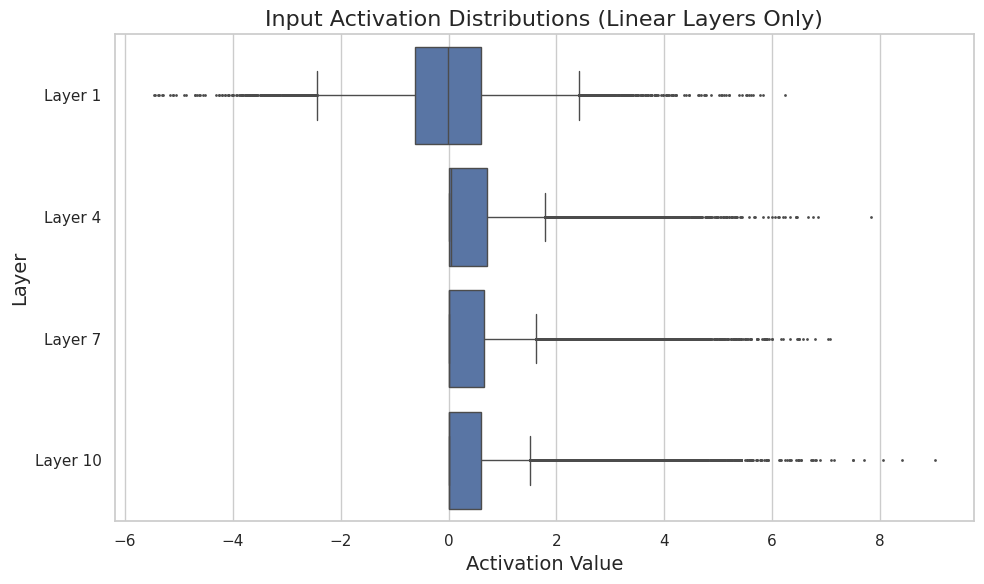

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Load your trained model (adjust path if needed)
model = torch.load('neural_networks/HOVER_TO_HOVER_NOMINAL_BN.pt', weights_only=False)
model.eval()

# Define target layers by their string names in model.named_modules()
# target_layers = ['1', '3', '5', '7']
target_layers = ['1', '4', '7', '10']

# Dict to hold inputs for each target layer
layer_inputs = {layer_name: [] for layer_name in target_layers}

# Hook function to store input activations
def hook_fn(layer_name):
    def hook(module, input, output):
        layer_inputs[layer_name].append(input[0].detach().cpu())
    return hook

# Register hooks for only the target layers
hooks = []
for name, module in model.named_modules():
    if name in target_layers:
        h = module.register_forward_hook(hook_fn(name))
        hooks.append(h)
# # Add weights from the same target layers to the records list
# for name, module in model.named_modules():
#     if name in target_layers and hasattr(module, 'weight'):
#         weights = module.weight.detach().cpu().numpy().flatten()
#         for w in weights:
#             records.append({'Layer': f"Layer {name}", 'Activation': w, 'Type': 'Weight'})

# Run model on test_loader and collect activations
# Run model on just the first 10 batches of test_loader
with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        _ = model(data)
        if i >= 9:  # stop after 10 batches (0-based index)
            break

# After inference, remove hooks (good practice)
for h in hooks:
    h.remove()

# Prepare records for DataFrame: flatten all activations per layer
records = []
for layer_name in target_layers:
    if len(layer_inputs[layer_name]) == 0:
        print(f"No activations collected for layer {layer_name}!")
        continue
    # Concatenate batch tensors along dim=0 (batch dimension)
    layer_tensor = torch.cat(layer_inputs[layer_name], dim=0)
    # Flatten all activations
    flat_activations = layer_tensor.numpy().flatten()
    for val in flat_activations:
        records.append({'Layer': f"Layer {layer_name}", 'Activation': val})

# Create DataFrame
df = pd.DataFrame(records)

# Plot boxplot of activations per layer
plt.figure(figsize=(10, len(target_layers)*1.5))
sns.boxplot(data=df, y="Layer", x="Activation", orient="h", linewidth=1, fliersize=1)
plt.title("Input Activation Distributions (Linear Layers Only)", fontsize=16)
plt.xlabel("Activation Value", fontsize=14)
plt.ylabel("Layer", fontsize=14)
plt.tight_layout()
plt.savefig("layer_input_summary_boxplot_BN.png", dpi=300)
plt.show()


**Saving model**

In [23]:
torch.save(model, 'neural_networks/Baseline_fp_normlize.pt')
torch.save({'network_state_dict': model.state_dict()}, 'neural_networks/Baseline_fp_normalize_sd.pt')

In [13]:
torch.save(model.state_dict(), 'neural_networks/Baseline_fp_BN_sd.pt')



In [9]:
model = torch.load('neural_networks/HOVER_TO_HOVER_NOMINAL_new.pt', weights_only=False)

In [10]:
model_processed_output =nn.Sequential(
    *model,
    MapToRange(dataset['omega_min'], dataset['omega_max'])
)

print(dataset)
torch.save(model_processed_output, 'neural_networks/HOVER_TO_HOVER_NOMINAL_.pt')

{'t': array([[0.        , 0.01133126, 0.02266252, ..., 2.22092738, 2.23225864,
        2.24358991],
       [0.        , 0.01171215, 0.02342429, ..., 2.29558065, 2.3072928 ,
        2.31900495],
       [0.        , 0.01244467, 0.02488935, ..., 2.43915621, 2.45160089,
        2.46404556],
       ...,
       [0.        , 0.01160842, 0.02321685, ..., 2.27525095, 2.28685938,
        2.2984678 ],
       [0.        , 0.00981751, 0.01963503, ..., 1.92423264, 1.93405015,
        1.94386767],
       [0.        , 0.01068914, 0.02137828, ..., 2.09507182, 2.10576097,
        2.11645011]]), 'dx': array([[-4.56538729e+00, -4.56794170e+00, -4.56652348e+00, ...,
         1.60031017e-07, -3.67448446e-08,  0.00000000e+00],
       [ 1.77525436e+00,  1.76413774e+00,  1.74862433e+00, ...,
         2.04954080e-07, -4.11014763e-08,  0.00000000e+00],
       [ 2.59538866e+00,  2.54422274e+00,  2.47515129e+00, ...,
         5.85759222e-07, -1.25425660e-07,  0.00000000e+00],
       ...,
       [-9.45990141e-01, -

In [11]:
import torch

# Load your trained model
model = torch.load('neural_networks/tmp_benchmark.pt', weights_only=False)
print(model[0])

# Apply dynamic quantization (works on Linear, LSTM)
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
print(quantized_model)
# Save quantized model
torch.save({'network_state_dict': model.state_dict()}, 'neural_networks/tmp_benchmark_quantized1.pt')

Normalize()
Sequential(
  (0): Normalize()
  (1): DynamicQuantizedLinear(in_features=16, out_features=120, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (2): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): DynamicQuantizedLinear(in_features=120, out_features=120, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (5): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): DynamicQuantizedLinear(in_features=120, out_features=120, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (8): BatchNorm1d(120, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): DynamicQuantizedLinear(in_features=120, out_features=4, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (11): BatchNorm1d(4, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (12): Sigmoid()
)


In [1]:
import torch
from Redbit.nn import QuantLinear  # RedBit layer
from copy import deepcopy

# Load your original model
model = torch.load('neural_networks/tmp_benchmark.pt', weights_only=False)
model.eval()

# Replace all Linear layers with QuantLinear
def replace_linear_with_quant(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            quant_layer = QuantLinear(
                in_features=child.in_features,
                out_features=child.out_features,
                bias=child.bias is not None,
                bit=8  # <-- 8-bit quantization
            )
            quant_layer.weight.data = deepcopy(child.weight.data)
            if child.bias is not None:
                quant_layer.bias.data = deepcopy(child.bias.data)
            setattr(module, name, quant_layer)
        else:
            replace_linear_with_quant(child)

replace_linear_with_quant(model)

# Save the modified model
torch.save(model, 'neural_networks/tmp_benchmark_redbit_quantized.pt')
load

# Optional: print the quantized model
print(model)


ModuleNotFoundError: No module named 'Redbit'

In [1]:
from tqdm import tqdm

# Use quantized model
model = quantized_model
model.eval()

loader = test_loader
running_loss = 0

loop = tqdm(enumerate(loader), total=len(loader), leave=False)

for i, (data, targets) in loop:
    data = data.cpu()      # ensure inputs are on CPU
    targets = targets.cpu()

    outputs = model(data)
    loss = criterion(outputs, targets)

    running_loss += loss.item()

    loop.set_postfix(loss=loss.item())

loop.close()
print('average loss =', running_loss / len(loader))


NameError: name 'quantized_model' is not defined

In [18]:
# Hamming distance
import torch
import torch.nn as nn
import collections
import csv

# Load the quantized model
model = torch.load('neural_networks/tmp_benchmark_quantized.pt', weights_only=False)
model.eval()

# Hamming distance between 8-bit integers
def hamming_distance(a, b=0):
    return bin(a ^ b).count("1")

# Initialize total counter for all layers (using absolute values)
global_counter = collections.Counter()
global_total = 0

# Aggregate all quantized weights (absolute values) across all layers
for name, module in model.named_modules():
    if isinstance(module, nn.quantized.dynamic.Linear):
        weight = module._packed_params._weight_bias()[0]
        flat = weight.int_repr().view(-1).cpu().numpy()
        flat_abs = abs(flat)  # take absolute values
        global_counter.update(flat_abs)
        global_total += flat_abs.size

print(f"\nTotal quantized weights (absolute values) in model: {global_total}")

# Output file
output_csv = "quantized_weight_analysis_global_abs.csv"
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)            
    writer.writerow(["Quantized Value (abs)", "Count", "Percentage", "Hamming Distance", "Hamming x Percentage"])

    # Values from 0 to 127 since we're using absolute values
    for val in range(0, 128):
        count = global_counter.get(val, 0)
        percentage = (count / global_total) * 100 if global_total > 0 else 0
        hamming = hamming_distance(val & 0xFF, 0)  # 8-bit representation of abs value
        weighted_hamming = hamming * percentage

        writer.writerow([
            val,
            count,
            f"{percentage:.2f}",
            hamming,
            f"{weighted_hamming:.2f}"
        ])

print(f"\nGlobal quantized weight distribution (absolute values) saved to: {output_csv}")



Total quantized weights (absolute values) in model: 31200

Global quantized weight distribution (absolute values) saved to: quantized_weight_analysis_global_abs.csv


In [14]:

import sys
sys.path.append('/home/RedBit/QNN/')  # Adjust path as needed
import torch.nn as nn
from tools import *

class QuantizedModel(nn.Module):
    def __init__(self, wbits=4, abits=4):
        super(QuantizedModel, self).__init__()
        self.abits = abits
        self.wbits = wbits

        if self.abits == 32:
            self.act = nn.ReLU(inplace=True)
        else:
            self.act = nn.Hardtanh(inplace=True)

        self.model = nn.Sequential(
            # Normalize(mean=X_mean, std=X_std),

            QLinear(abits=self.abits, wbits=self.wbits, in_features=16, out_features=120, bias=False),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1, affine=True),
            self.act,

            QLinear(abits=self.abits, wbits=self.wbits, in_features=120, out_features=120, bias=False),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1, affine=True),
            self.act,

            QLinear(abits=self.abits, wbits=self.wbits, in_features=120, out_features=120, bias=False),
            nn.BatchNorm1d(120, eps=1e-4, momentum=0.1, affine=True),
            self.act,

            QLinear(abits=self.abits, wbits=self.wbits, in_features=120, out_features=4, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [3]:
import sys
# sys.path.insert(0,'/home/RedBit/QNN/models/')  # Adjust path as needed
# sys.path.remove('/home/RedBit/Baseline/tools/')
# Remove wrong path
wrong_path = '/home/RedBit/Baseline/tools'
if wrong_path in sys.path:
    sys.path.remove(wrong_path)

# Force correct path at the front
correct_path = '/home/RedBit/QNN/'
if correct_path in sys.path:
    sys.path.remove(correct_path)
sys.path.insert(0, correct_path)

# Clear cached wrong module
if 'tools' in sys.modules:
    del sys.modules['tools']
print(sys.path)
from tools import quantization
# from quantization import QLinear
# from RedBit.quantizer import quantize_pytorch_model
import torch



# Load model
model = torch.load('neural_networks/tmp_benchmark.pt' , weights_only=False)

# Quantize to 4-bit weights and activations
quantized_model = QuantizedModel(model)

# Save
torch.save(quantized_model, 'neural_networks/tmp_benchmark_quantized_int4.pt')

['/home/RedBit/QNN/', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/aelarrassi/environments/drone_env/lib/python3.10/site-packages', '/tmp/tmplsdnbq2l']


NameError: name 'QuantizedModel' is not defined

In [2]:
# from quantizer import quantize_pytorch_model
import torch
# Load quantized model
quantized_model = torch.load('neural_networks/tmp_benchmark_quantized_int4.pt', weights_only=False)
quantized_model.eval()

# Your existing test loop
from tqdm import tqdm

loader = test_loader
loop = tqdm(enumerate(loader), total=len(loader), leave=False)
running_loss = 0

for i, (data, targets) in loop:
    outputs = quantized_model(data)
    loss = criterion(outputs, targets)
    running_loss += loss.item()
    loop.set_postfix(loss=loss.item())

loop.close()
print('average loss =', running_loss / len(loader))


AttributeError: Can't get attribute 'QuantizedModel' on <module '__main__'>